<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#WHO-data" data-toc-modified-id="WHO-data-1">WHO data</a></span><ul class="toc-item"><li><span><a href="#measles-cases-data" data-toc-modified-id="measles-cases-data-1.1">measles cases data</a></span></li><li><span><a href="#vaccination-coverage-data" data-toc-modified-id="vaccination-coverage-data-1.2">vaccination coverage data</a></span></li></ul></li><li><span><a href="#Population-data" data-toc-modified-id="Population-data-2">Population data</a></span></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-3">Data Exploration</a></span><ul class="toc-item"><li><span><a href="#merging-dataframes" data-toc-modified-id="merging-dataframes-3.1">merging dataframes</a></span></li><li><span><a href="#aggregated-distributions-VS-time" data-toc-modified-id="aggregated-distributions-VS-time-3.2">aggregated distributions VS time</a></span></li><li><span><a href="#largest-outbreaks" data-toc-modified-id="largest-outbreaks-3.3">largest outbreaks</a></span></li><li><span><a href="#prevalence-and-vacc-VS-t" data-toc-modified-id="prevalence-and-vacc-VS-t-3.4">prevalence and vacc VS t</a></span></li><li><span><a href="#dist-of-correlation(prevalence(t),vacc(t)-)" data-toc-modified-id="dist-of-correlation(prevalence(t),vacc(t)-)-3.5">dist of correlation(prevalence(t),vacc(t) )</a></span></li></ul></li><li><span><a href="#NA\EU" data-toc-modified-id="NA\EU-4">NA\EU</a></span><ul class="toc-item"><li><span><a href="#full-data-plot" data-toc-modified-id="full-data-plot-4.1">full data plot</a></span></li><li><span><a href="#averages-plot" data-toc-modified-id="averages-plot-4.2">averages plot</a></span></li></ul></li></ul></div>

<center>
    <big>
        <b>
            MEASLES DATA ANALYSIS 
        </b>
    </big>

</center>

<center>
        here we analyze data from public health authorities on the recent measles outbreaks 
</center>

In [2]:
import pandas as pd

# packages to plot
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import gc

# WHO data

[Measles](https://en.wikipedia.org/wiki/Measles)
is one of the most infectious disease, with a basic reproductive number [$R_0$ in the range 12-18](https://en.wikipedia.org/wiki/Basic_reproduction_number)

## measles cases data

We got the `measlescasesbycountrybymonth.xlsx` dataset from [WHO Measles and Rubella Surveillance Data](http://www.who.int/immunization/monitoring_surveillance/burden/vpd/surveillance_type/active/measles_monthlydata/en/) - 
mind that there are _some discrepancy_ with the official data released by the country-specific institutions for disease control (CDC, etc...);      

In [3]:
who_cases_df = pd.read_excel('./datasets/measlescasesbycountrybymonth.xls',sheet_name='WEB')

print(who_cases_df.shape)

who_cases_df.head()

(1746, 16)


,Region,ISO3,Country,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,AFR,AGO,Angola,2011,17.0,19.0,37.0,41.0,11.0,8.0,5.0,4.0,32.0,10.0,8.0,0.0
1,AFR,AGO,Angola,2012,373.0,289.0,381.0,393.0,546.0,357.0,382.0,553.0,571.0,367.0,216.0,42.0
2,AFR,AGO,Angola,2013,725.0,646.0,734.0,491.0,726.0,695.0,680.0,660.0,563.0,288.0,265.0,91.0
3,AFR,AGO,Angola,2014,1161.0,1101.0,1319.0,1094.0,1754.0,1150.0,1484.0,1429.0,1098.0,373.0,27.0,12.0
4,AFR,AGO,Angola,2015,4.0,15.0,0.0,0.0,3.0,3.0,4.0,13.0,40.0,14.0,5.0,2.0


cleaning the df 

In [4]:
# add sum column in cases df
who_cases_df['cases']  = who_cases_df.iloc[:,4:16].sum(axis=1)

# drop monthly data - we won't use such resolution for now
who_cases_df.drop(['Region','January', 'February', 'March', 'April',
                   'May', 'June', 'July', 'August',
                   'September', 'October', 'November','December'],axis=1,inplace=True)

# fix name of column with ISO code 
who_cases_df.columns = ['ISO_code', 'Country', 'year', 'cases']

print(who_cases_df.shape)
print(who_cases_df.isnull().sum())
who_cases_df.head()

(1746, 4)
ISO_code    0
Country     0
year        0
cases       0
dtype: int64


,ISO_code,Country,year,cases
0,AGO,Angola,2011,192.0
1,AGO,Angola,2012,4470.0
2,AGO,Angola,2013,6564.0
3,AGO,Angola,2014,12002.0
4,AGO,Angola,2015,103.0


distribution of N. data time-points, per country

In [5]:
#  all countries have 9 data points 
who_cases_df.ISO_code.value_counts().value_counts() 

9    194
Name: ISO_code, dtype: int64

In [6]:
# ...in the time-range:
print(who_cases_df.year.min())
print(who_cases_df.year.max())

2011
2019


## vaccination coverage data

[WHO data on Immunization, Vaccines and Biologicals](http://www.who.int/immunization/monitoring_surveillance/data/en/), 
where you can find the word-wide coverage for 
[MCV dose 1](http://apps.who.int/immunization_monitoring/globalsummary/timeseries/tscoveragemcv1.html) 
and
[MCV dose 2](http://apps.who.int/immunization_monitoring/globalsummary/timeseries/tscoveragemcv2.html) - 
for the time being we focus only on the 1st dose 
(as it should already give most of the immunization, and it's therefore enough for our purposes)

we consider the `Official country reported coverage estimates` -- which differ, for some countries from the `country reported administrative data`


(* indicates the country reported above  or equal to 100% coverage.)

In [7]:
who_vacc_df = pd.read_excel('./datasets/coverage_series.xls',sheet_name='world_coverage')

# select for vaccine dose
# who_vacc_df = who_vacc_df[who_vacc_df.Vaccine=='MCV1']
who_vacc_df = who_vacc_df[who_vacc_df.Vaccine=='MCV2']

# drop useless cols 
who_vacc_df.drop(['Cname','WHO_REGION','Continent','Vaccine','Asterisc'],axis=1,inplace=True)


# fix col names
who_vacc_df.columns = ['ISO_code', 'year', 'vacc_cov']

# MCV1 VS MCV2
# who_vacc_df = who_vacc_df[(who_vacc_df.Vaccine=='MCV1') | (who_vacc_df.Vaccine=='MCV2')]
# who_vacc_df.drop(['Cname','WHO_REGION','Continent','Asterisc'],axis=1,inplace=True) 

print(who_vacc_df.shape)
who_vacc_df.head()

(2236, 3)


,ISO_code,year,vacc_cov
158,AFG,2004,2.0
159,AFG,2005,13.0
160,AFG,2006,26.0
161,AFG,2007,16.0
162,AFG,2008,39.0


In [187]:
# quick check for weird data 'MCV2' > 'MCV1' !!!
grouped_who_vacc_df = who_vacc_df.set_index(['ISO_code','Year'])
grouped_who_vacc_df = grouped_who_vacc_df.pivot(columns='Vaccine')
grouped_who_vacc_df.columns = ['MCV1','MCV2']

print(grouped_who_vacc_df.isnull().sum())

grouped_who_vacc_df['weird'] = grouped_who_vacc_df.MCV2 > grouped_who_vacc_df.MCV1
grouped_who_vacc_df.weird.sum()

MCV1      20
MCV2    4426
dtype: int64


392

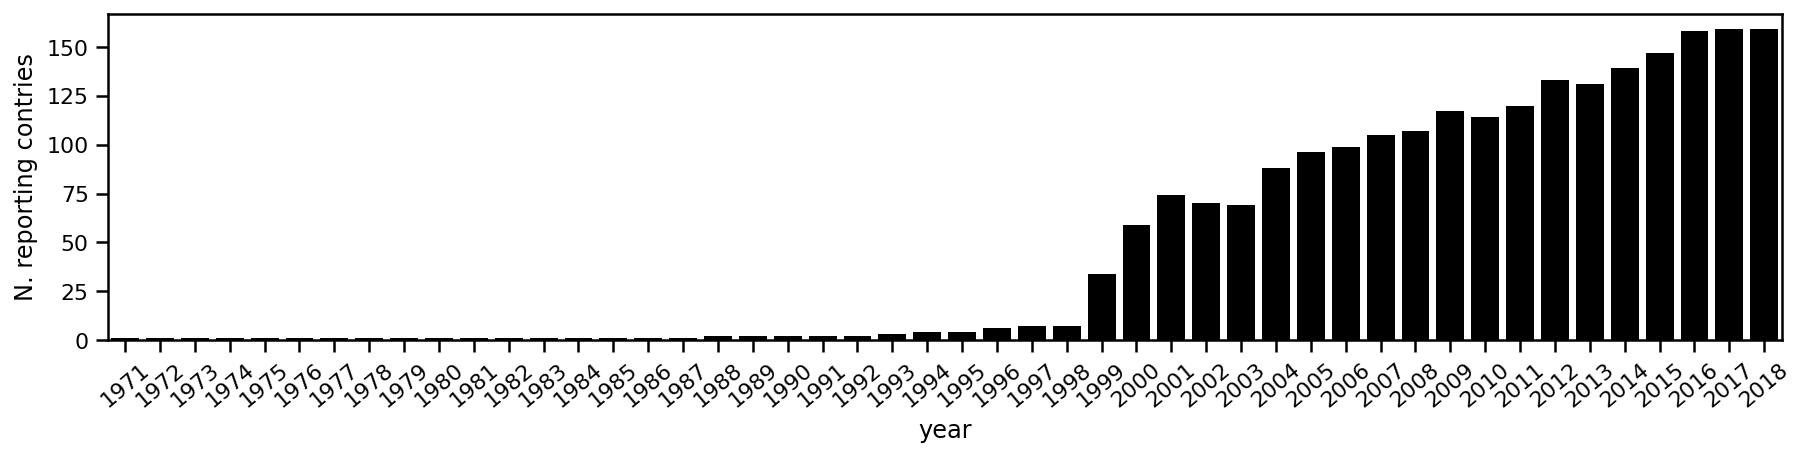

In [8]:
plt.figure(figsize=(15,3))
sns.countplot(who_vacc_df.year,color='k')
plt.ylabel('N. reporting contries')
plt.xticks(rotation=40);

check whether countries are the same: 

(better to use the `ISO code`, as the `country names` are not the same across the 2 datasets - mainly becasue of articles)

(mind that there are [193 UN recognized countries](https://www.countries-ofthe-world.com/all-countries.html))

In [9]:
# check number of countries

print('countries in prevalence df:',who_cases_df.ISO_code.nunique())
print('countries in vaccination df:',who_vacc_df.ISO_code.nunique())

# it seems there are no problems...

# print('countries in who_vacc_df, not in who_cases_df')
# [print(my_c) for my_c in who_vacc_df.ISO_code.unique() if my_c not in who_cases_df.ISO_code.unique()];


print('countries in who_cases_df, not in who_vacc_df')
[print(my_c) for my_c in who_cases_df.ISO_code.unique() if my_c not in who_vacc_df.ISO_code.unique()];

countries in prevalence df: 194
countries in vaccination df: 170
countries in who_cases_df, not in who_vacc_df
BEN
CAF
CIV
CMR
COD
COG
COM
ETH
GAB
GIN
GNB
GNQ
LBR
MDG
MLI
MRT
NGA
SSD
TCD
TGO
UGA
SOM
IRL
VUT


filter also for min year, since when incidence data start

In [10]:
print(who_cases_df.year.min())
print(who_vacc_df.year.min())

who_vacc_df = who_vacc_df[who_vacc_df.year >= who_cases_df.year.min()]

# double check
print(who_vacc_df.year.min())
who_vacc_df.shape

2011
1971
2011


(1146, 3)

# Population data

we got the population from the [work bank data platform](http://data.worldbank.org/indicator/SP.POP.TOTL?end=2016&start=2011&view=chart&year=1964)

In [12]:
word_pop_tot = pd.read_csv('./API_SP/world_pop.csv',header=2,index_col=0)

print(word_pop_tot.shape)
word_pop_tot.head()

(264, 63)


,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,10174836.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,5781214.0,...,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,...,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,...,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN


cleaning df 

In [13]:
# remove useless cols - we have measles data only for the last 6 year

word_pop_tot.drop(['Indicator Name', 'Indicator Code', '1960', '1961',
       '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970',
       '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010','Unnamed: 63'],axis=1,inplace=True)

# fixing the col names
word_pop_tot.columns = ['ISO_code', '2011', '2012', '2013', '2014', '2015', '2016','2017','2018']

# show result on df
print(word_pop_tot.shape)
print(word_pop_tot.isnull().sum())
word_pop_tot.head()

(264, 9)
ISO_code    0
2011        1
2012        2
2013        2
2014        2
2015        2
2016        2
2017        2
2018        2
dtype: int64


,ISO_code,2011,2012,2013,2014,2015,2016,2017,2018
Country Name,,,,,,,,,
Aruba,ABW,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0
Afghanistan,AFG,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0
Angola,AGO,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0
Albania,ALB,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0
Andorra,AND,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0


melting the df

In [14]:
melted_pop = pd.melt(word_pop_tot,
                     value_name='population',
                     var_name='year',
                     id_vars='ISO_code')

# delete the previous df, as we don't need it anymore  
del word_pop_tot
gc.collect()

# show new df
print(melted_pop.shape)
melted_pop.head()

(2112, 3)


,ISO_code,year,population
0,ABW,2011,102046.0
1,AFG,2011,30117413.0
2,AGO,2011,24220661.0
3,ALB,2011,2905195.0
4,AND,2011,83747.0


In [15]:
# convert year type to int, in order to avoid issues with merging later
melted_pop.year = melted_pop.year.astype('int64')

melted_pop.dtypes

ISO_code       object
year            int64
population    float64
dtype: object

quick stats on population dataset

In [16]:
melted_pop.ISO_code.value_counts().value_counts()

8    264
Name: ISO_code, dtype: int64

In [17]:
# ...in the time-range:
print(melted_pop.year.min())
print(melted_pop.year.max())

2011
2018


# Data Exploration

##  merging dataframes

mind that the number of time points is quite different for the 2 datasets

In [19]:
print(who_cases_df.year.unique())
print(who_vacc_df.year.unique())

[2011 2012 2013 2014 2015 2016 2017 2018 2019]
[2011 2012 2013 2014 2015 2016 2017 2018]


merging the vacc. coverage, cases and population, by `ISO code` and `year` – drop nans

In [22]:
measles_df = pd.merge(pd.merge(who_cases_df,who_vacc_df,how='outer',on=['ISO_code','year']),
                               melted_pop,how='outer',on=['ISO_code','year'])

# remove country - we can always recover it from the who_cases_df
measles_df.drop('Country',axis=1,inplace=True)

# show new df
print(measles_df.isnull().sum())

# remove NaNs - if we need more data on vacc, can be taken from the original df --> see next section
print('measles_df.shape before dropna:',measles_df.shape)
measles_df.dropna(inplace=True)
print('measles_df.shape after dropna:',measles_df.shape)

measles_df.head()

ISO_code         0
year             0
cases          576
vacc_cov      1177
population     225
dtype: int64
measles_df.shape before dropna: (2322, 5)
measles_df.shape after dropna: (1126, 5)


,ISO_code,year,cases,vacc_cov,population
4,AGO,2015,103.0,26.0,27884381.0
5,AGO,2016,51.0,26.0,28842484.0
6,AGO,2017,27.0,30.0,29816748.0
7,AGO,2018,57.0,35.0,30809762.0
11,BDI,2013,0.0,51.0,9540289.0


add `prevalence` column and sort  df by year

In [23]:
measles_df['prevalence'] = measles_df.cases / measles_df.population * 10**6

# sort by year
measles_df.sort_values('year',inplace=True)

measles_df.head()

,ISO_code,year,cases,vacc_cov,population,prevalence
432,ATG,2011,0.0,89.0,89253.0,0.000000
1053,ESP,2011,3508.0,91.0,46742697.0,75.049157
918,YEM,2011,847.0,54.0,23807588.0,35.576893
1188,LTU,2011,7.0,94.0,3028115.0,2.311669
1413,BTN,2011,10.0,95.0,693298.0,14.423812


## aggregated distributions VS time

dist. of vacc over time

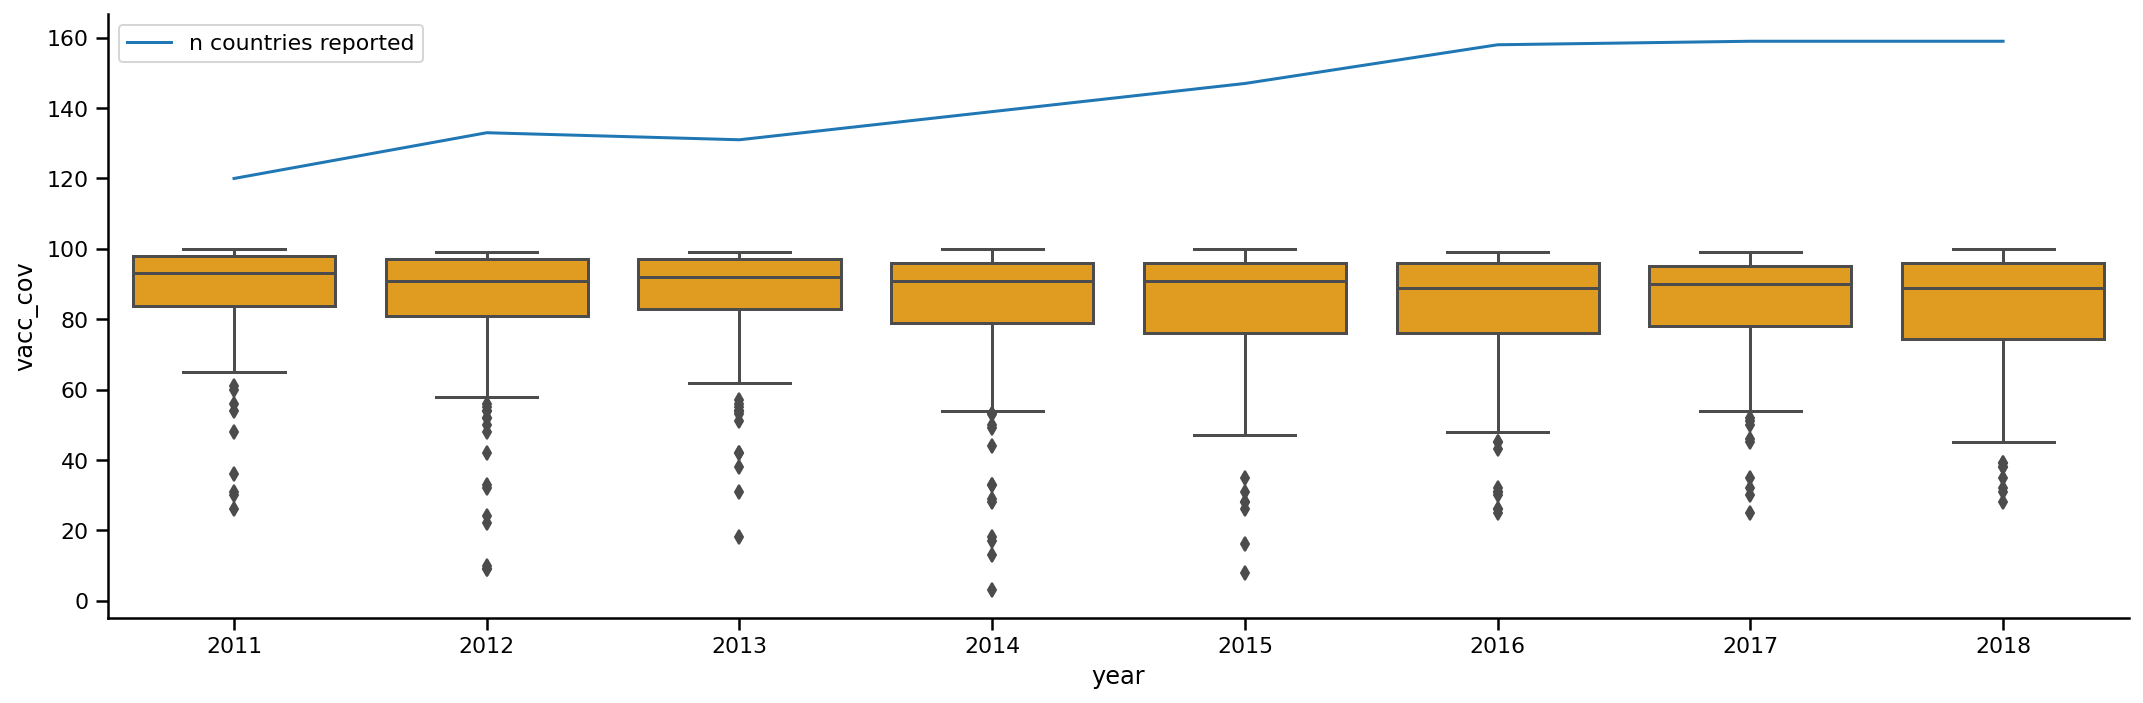

In [28]:
sns.catplot(data=who_vacc_df,
            y='vacc_cov',
            kind='box',
            x='year',
            aspect=3,
            color='orange')

plt.plot([who_vacc_df[who_vacc_df.year == my_y].ISO_code.nunique()
          for my_y in np.sort(who_vacc_df.year.unique())
          ],
         label='n countries reported')

plt.legend()
plt.show()

dist. of prevalence over time

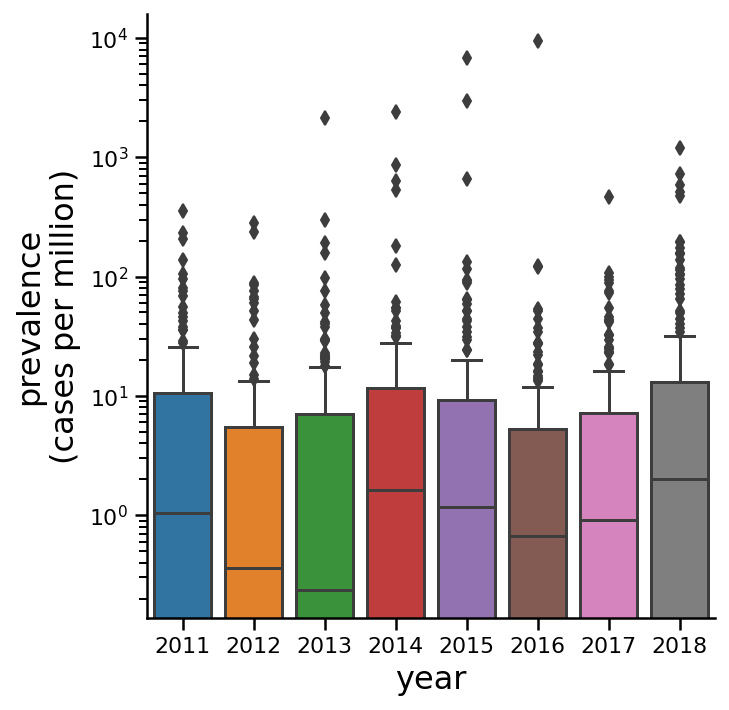

In [29]:
sns.catplot(data=measles_df[measles_df.prevalence.notnull()],
            y='prevalence',
            x='year',
            kind='box')

plt.yscale('log')

plt.ylabel('prevalence\n(cases per million)', size=16)
plt.xlabel('year', size=16)

## largest outbreaks

one could set a prevalence threshold for instance >= 0.1 %  (1000 per million)   

or

from [WHO guidelines](https://www.ncbi.nlm.nih.gov/books/NBK143963/):

> A confirmed measles outbreak is defined as the occurrence of three or more confirmed measles cases (at least two of which should be laboratory-confirmed; IgM positive) in a health facility/district/block (approximate catchment population of 100 000) in a month.

...which means >= 360 / (year * M ppl) 

In [30]:
# high_prev_countries = measles_df[measles_df.prevalence > 1000].ISO_code.unique()
high_prev_countries = measles_df.ISO_code[measles_df.prevalence > 360].unique()

WHO reported cases for country with high measles prevalence:
(as listed in the above) -- [check here ISO country codes](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3#Current_codes)

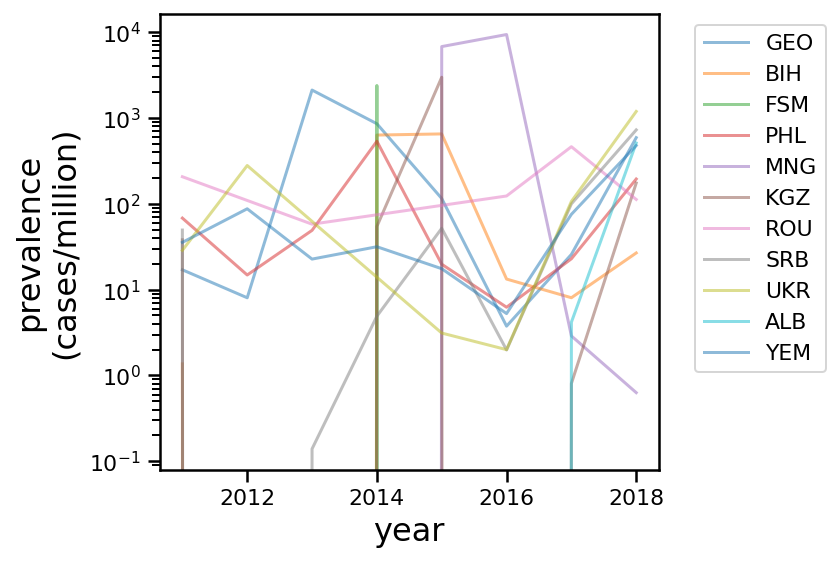

In [38]:
for my_country in high_prev_countries:

    plt.plot(measles_df.year[measles_df.ISO_code == my_country],
             measles_df.prevalence[measles_df.ISO_code == my_country],
             label=my_country,
             alpha=0.5)

plt.ylabel('prevalence\n(cases/million)', size=16)
plt.xlabel('year', size=16)

plt.yscale('log')
plt.legend(bbox_to_anchor=[1.05, 1])

plt.tight_layout()

for __Europe__, largest outbreaks were in: Romania, [Georgia](http://www.euro.who.int/en/countries/georgia/news/news/2013/08/georgia-expands-immunization-campaign-to-prevent-further-spread-of-measles) , Bosnia, Albania, Ukrania, Serbia

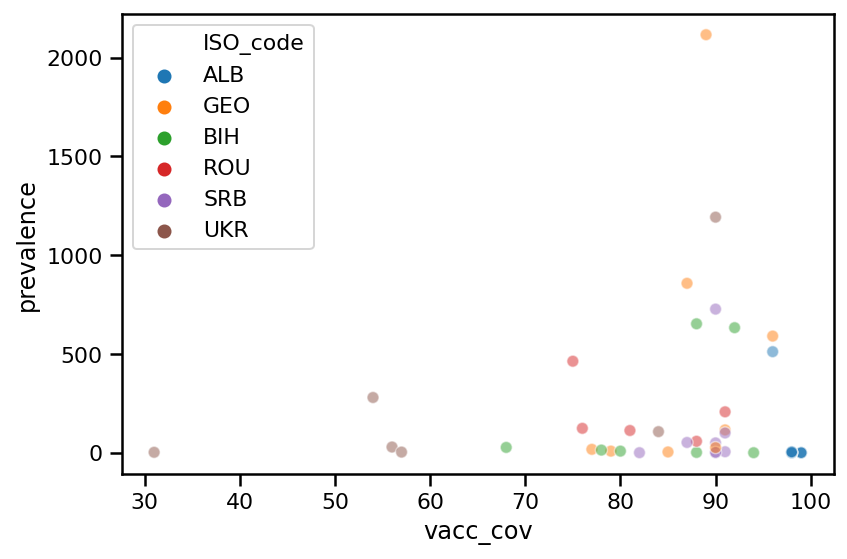

In [40]:
largest_outb_europe = ['GEO','ROU','BIH','ALB','SRB','UKR']

sns.scatterplot(data=measles_df[measles_df.ISO_code.isin(largest_outb_europe)],
                x='vacc_cov',y='prevalence',hue='ISO_code',alpha=0.5);

plt.tight_layout()

Apart from [Micronesia](https://en.wikipedia.org/wiki/Federated_States_of_Micronesia), the  data from those other countries are quite scaring ...

Probably the most frightening case was the 
[2015-2016 outbreaks in Mongolia](http://www.wpro.who.int/mongolia/mediacentre/releases/20160505-measles-outbreak-faqs/en/), 
__although the high vaccination rate__ 

In [41]:
measles_df[measles_df.ISO_code=='MNG']

,ISO_code,year,cases,vacc_cov,population,prevalence
1611,MNG,2011,0.0,98.0,2770362.0,0.000000
1612,MNG,2012,0.0,98.0,2824699.0,0.000000
1613,MNG,2013,0.0,97.0,2881792.0,0.000000
1614,MNG,2014,0.0,98.0,2940108.0,0.000000
1615,MNG,2015,20376.0,98.0,2998439.0,6795.535944
1616,MNG,2016,28710.0,90.0,3056359.0,9393.530014
1617,MNG,2017,9.0,98.0,3113779.0,2.890379
1618,MNG,2018,2.0,98.0,3170208.0,0.630873


...and [Kyrgyzstan](http://www.euro.who.int/en/health-topics/communicable-diseases/measles-and-rubella/news/news/2015/06/kyrgyzstan-back-on-track-to-prevent-measles-and-rubella-outbreaks)



In [42]:
measles_df[measles_df.ISO_code=='KGZ']

,ISO_code,year,cases,vacc_cov,population,prevalence
1179,KGZ,2011,210.0,98.0,5514600.0,38.080731
1180,KGZ,2012,0.0,98.0,5607200.0,0.000000
1181,KGZ,2013,0.0,97.0,5719600.0,0.000000
1182,KGZ,2014,318.0,97.0,5835500.0,54.494045
1183,KGZ,2015,17779.0,96.0,5956900.0,2984.606087
1184,KGZ,2016,0.0,98.0,6079500.0,0.000000
1185,KGZ,2017,5.0,96.0,6198200.0,0.806686
1186,KGZ,2018,1104.0,96.0,6315800.0,174.799709


## prevalence and vacc VS t

here are few examples of cases to show correlation between  coverage  as cases across time - for few countries

In [45]:
def single_coutry_plot(country_to_plot,wanna_legend=True):
    
    sel_data = measles_df.ISO_code==country_to_plot

    plt.scatter(measles_df.year[sel_data],
            measles_df.vacc_cov[sel_data],
            label='vacc coverage')

    plt.scatter(measles_df.year[sel_data],
            measles_df.prevalence[sel_data],
            label='prevalence')

    plt.title('%s'%(country_to_plot))
    
    if wanna_legend:
        plt.legend();

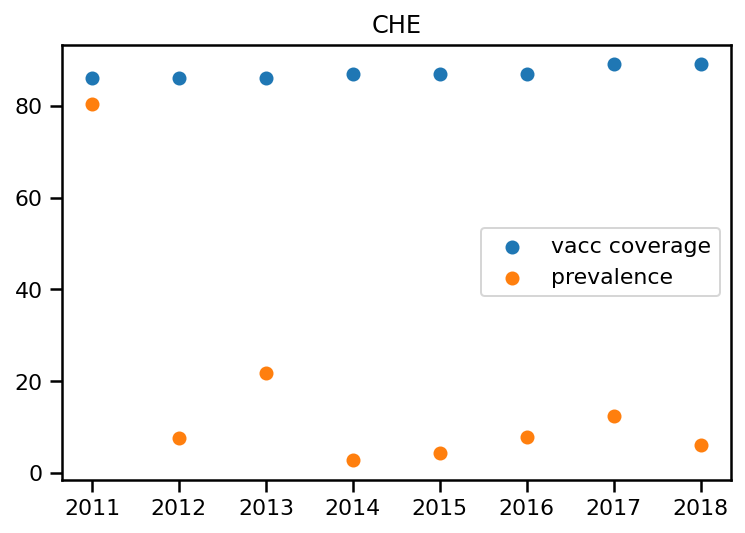

In [46]:
single_coutry_plot('CHE')

# NA\EU

Given the sometimes 'weird' results got from the WHO data and the fact that national surveillance systems in other countries are sometimes less reliable, we focus on North American and West EU countries

In [48]:
my_countries = ['USA','CAN',
               'ITA','FRA','DEU','CHE','GBR','ESP']

## full data plot

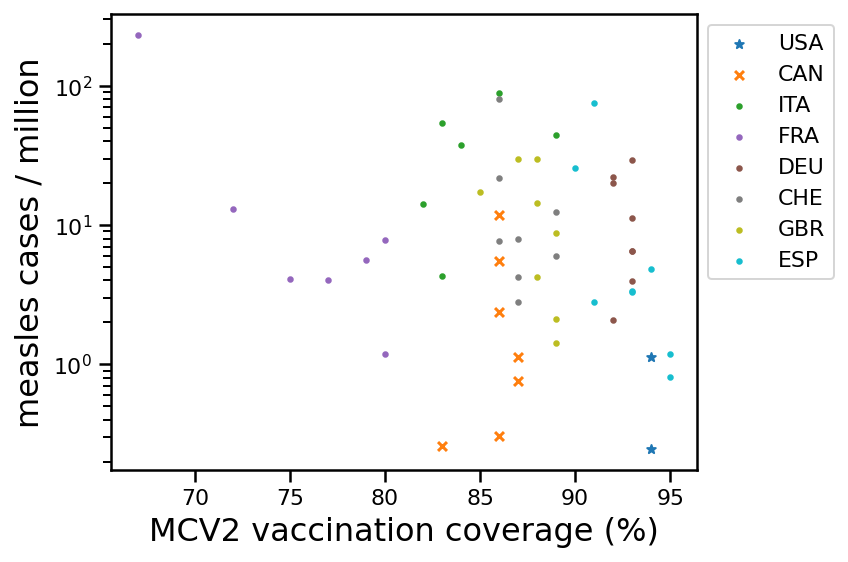

In [53]:
# chose color map
cmap = plt.get_cmap('tab10')
my_colors = cmap(np.linspace(0, 1, len(my_countries)))

for my_c, i in zip(my_countries, range(len(my_countries))):

    data_filter = (measles_df.ISO_code == my_c) & (measles_df.prevalence > 0)

    if my_c == 'USA':
        my_marker = '*'
    elif my_c == 'CAN':
        my_marker = 'x'
    else:
        my_marker = '.'

    plt.scatter(measles_df.vacc_cov[data_filter],
                measles_df.prevalence[data_filter],
                label=my_c,
                s=20,
                marker=my_marker,
                c=my_colors[i, ].reshape(1, my_colors.shape[1]))

plt.yscale('log')

plt.ylabel('measles cases / million', size=16)
plt.xlabel('MCV2 vaccination coverage (%)', size=16)

plt.legend(bbox_to_anchor=[1, 1])

plt.tight_layout()

same plot – version with arrows

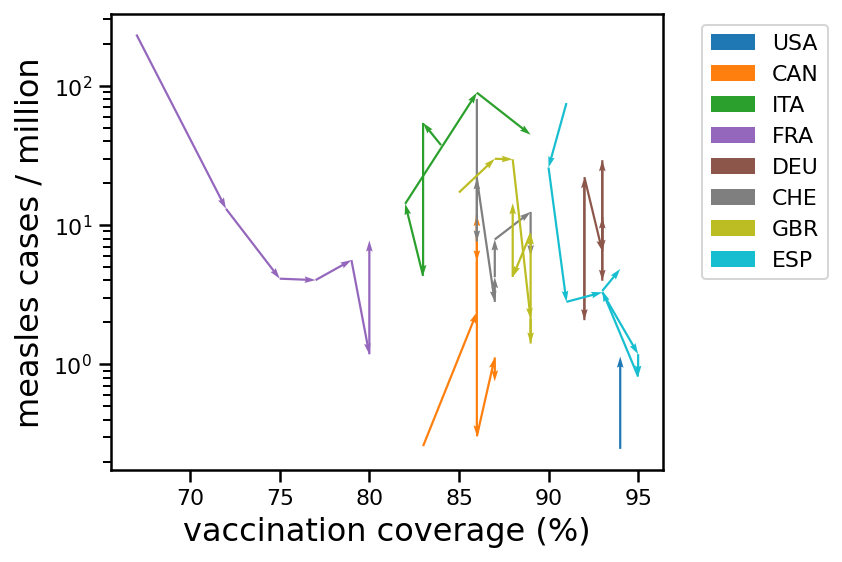

In [55]:
# chose color map for arrows
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(my_countries)))

for my_c, my_color in zip(my_countries, colors):

    # subset df with given coutry
    df = measles_df.loc[measles_df.ISO_code == my_c,
                        ['vacc_cov', 'prevalence', 'year']]

    # better to reset the index
    df.reset_index(drop=True, inplace=True)

    # plot arrows
    plt.quiver(df.vacc_cov.iloc[:-1],
               df.prevalence.iloc[:-1],
               df.vacc_cov.diff()[1:],
               df.prevalence.diff()[1:],
               color=my_color,
               scale_units='xy',
               angles='xy',
               scale=1,
               width=0.004,
               label=my_c)

plt.yscale('log')

plt.ylabel('measles cases / million', size=16)
plt.xlabel('vaccination coverage (%)', size=16)

plt.legend(bbox_to_anchor=[1.05, 1])
# plt.legend()

plt.tight_layout()

## averages plot

In [56]:
# remove useless var
who_cases_df.drop(labels='Country',inplace=True,axis=1)

In [59]:
print(melted_pop.year.unique())
print(who_cases_df.year.unique())
print(who_vacc_df.year.unique())

[2011 2012 2013 2014 2015 2016 2017 2018]
[2011 2012 2013 2014 2015 2016 2017 2018 2019]
[2011 2012 2013 2014 2015 2016 2017 2018]


In [60]:
# subset years and countries first
filters_cases = (who_cases_df.year.isin(melted_pop.year.unique())) & \
            (who_cases_df.ISO_code.isin(my_countries))

# compute tot cases sum ...
cases_sum = who_cases_df.loc[filters_cases,['ISO_code','cases']].groupby('ISO_code').sum().cases

# subset for 
filters_pop = melted_pop.ISO_code.isin(my_countries)

# ...and average pop 
average_pop = melted_pop.loc[filters_pop,['ISO_code','population']].groupby('ISO_code').mean().population

# and normalize
norm_tot_cases = cases_sum /average_pop * 10**6

del cases_sum,average_pop
gc.collect();

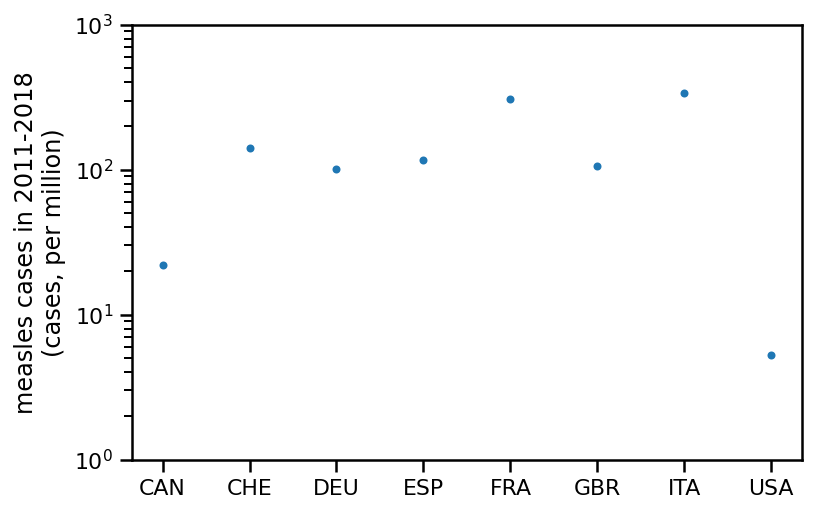

In [61]:
# plot with NO vacc
plt.plot(norm_tot_cases,linestyle='',marker='.');
plt.ylabel('measles cases in 2011-2018\n(cases, per million)')

plt.yscale('log');
plt.ylim([1,1e3]);

In [62]:
# subset years and countries first
filters_vacc = (who_vacc_df.ISO_code.isin(my_countries)
                & who_vacc_df.year.isin(melted_pop.year.unique()))

# compute average vacc...
average_vacc = who_vacc_df.loc[filters_vacc, ['ISO_code', 'vacc_cov']].groupby(
    'ISO_code').mean().vacc_cov

# ...and merge
norm_tot_cases_aver_vacc = {
    'norm_tot_cases': norm_tot_cases,
    'average_vacc': average_vacc
}

norm_tot_cases_aver_vacc = pd.DataFrame(norm_tot_cases_aver_vacc)
norm_tot_cases_aver_vacc['Country'] = [
    'Canada', 'Switzerland', 'Germany', 'Spain', 'France', 'UK', 'Italy', 'USA'
]

del norm_tot_cases, average_vacc

In [63]:
# set new order to highlight diff. EU VS north-america
new_order = ['CAN', 'USA', 'CHE', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA']
norm_tot_cases_aver_vacc = norm_tot_cases_aver_vacc.reindex(index=new_order)

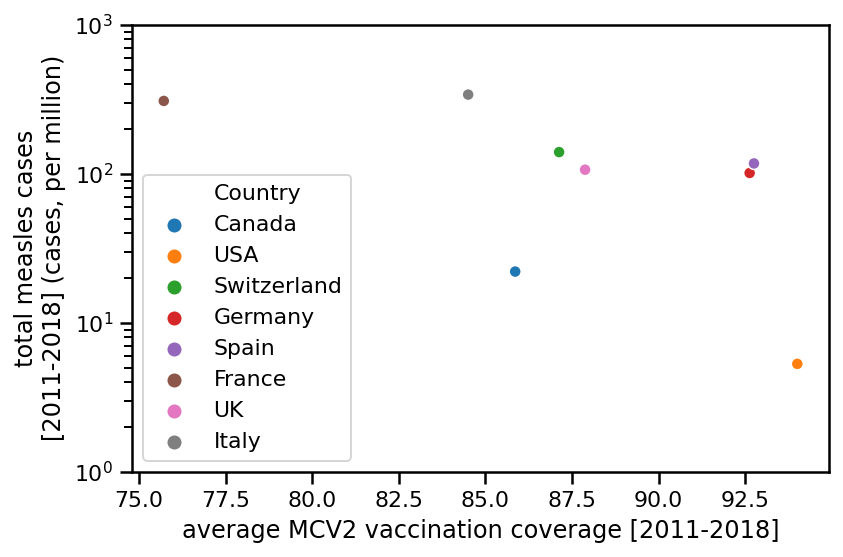

In [66]:
aver_cases_plot = sns.scatterplot('average_vacc',
                                  'norm_tot_cases',
                                  'Country',
                                  data=norm_tot_cases_aver_vacc)

plt.yscale('log')
plt.ylim([1, 1e3])

plt.ylabel('total measles cases\n[2011-2018] (cases, per million)')
plt.xlabel('average MCV2 vaccination coverage [2011-2018]')

plt.tight_layout()
plt.savefig('us_westeu_prev_vacc_averaged.pdf')